In [1]:
import torch
import numpy as np
from tqdm import tqdm 
seed = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

set_seed(seed)

In [2]:
import os
import numpy as np
import cv2
from torch.utils.data import Dataset

class RetinaDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)


    def __getitem__(self, index):
        image_path = self.images_path[index]
        mask_path = self.masks_path[index]

        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if image is None:
                raise ValueError(f"Failed to load image at path: {image_path}")
            image = image / 255.0  
            image = np.transpose(image, (2, 0, 1))  #(3, 512, 512)
            image = torch.tensor(image, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading image: {str(e)}")
            raise e

        try:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise ValueError(f"Failed to load mask at path: {mask_path}")
            mask = mask / 255.0 
            mask = np.expand_dims(mask, axis=0)  # (1, 512, 512)
            mask = torch.tensor(mask, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading mask: {str(e)}")
            raise e

        return image, mask


    def __len__(self):
        return self.n_samples

In [3]:
from glob import glob

train_augmented_path_images = sorted(glob('/kaggle/input/augment-retina/training/images/*'))
train_augmented_path_1st_manual = sorted(glob('/kaggle/input/augment-retina/training/1st_manual/*'))

test_augmented_path_images = sorted(glob('/kaggle/input/augment-retina/test/images/*'))
test_augmented_path_1st_manual = sorted(glob('/kaggle/input/augment-retina/test/1st_manual/*'))

train_dataset = RetinaDataset(train_augmented_path_images, train_augmented_path_1st_manual)
test_dataset = RetinaDataset(test_augmented_path_images, test_augmented_path_1st_manual)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
import torch.nn as nn
from torch.nn import functional as F

class InConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
                )
    def forward(self, x):
        return self.conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
                nn.MaxPool2d(2),
                InConv(in_channels, out_channels)
                )
    def forward(self, x):
        return self.down(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                                    nn.Conv2d(in_channels, in_channels // 2, 1))
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
            
        self.conv = InConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        return self.conv(x)
    

class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)  #[1, 64, 256, 256]
        self.down1 = Down(64, 128)          #[1, 128, 128, 128]
        self.down2 = Down(128, 256)         #[1, 256, 64, 64]
        self.down3 = Down(256, 512)         #[1, 512, 32, 32]
        self.down4 = Down(512, 1024)        #[1, 1024, 16, 16]
        self.up1 = Up(1024, 512)            #[1, 512, 32, 32]
        self.up2 = Up(512, 256)             #[1, 256, 64, 64]
        self.up3 = Up(256, 128)             #[1, 128, 128, 128]
        self.up4 = Up(128, 64)              #[1, 64, 256, 256]
        self.outc = OutConv(64, classes)    #[1, 1, 256, 256]

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
    

In [6]:
class DICE_BCE_Loss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        logits= torch.sigmoid(logits)
        intersection = 2*(logits * targets).sum() + self.smooth
        union = (logits + targets).sum() + self.smooth
        dice_loss = 1. - intersection / union

        loss = nn.BCELoss()
        bce_loss = loss(logits, targets)

        return dice_loss + bce_loss
    
def dice_coeff(logits, targets):
    logits=torch.sigmoid(logits)
    intersection = 2*(logits * targets).sum()
    union = (logits + targets).sum()
    if union == 0:
        return 1
    dice_coeff = intersection / union
    return dice_coeff.item()


In [7]:
def train(model, trainloader, optimizer, loss, epochs):
    train_losses, val_losses = [], []
    train_dices, val_dices = [], []
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        train_dice = 0
        for i, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            logits = model(images)
            l = loss(logits, masks)
            l.backward()
            optimizer.step()
            train_loss += l.item()
            train_dice += dice_coeff(logits, masks)
        train_loss /= len(train_loader)
        train_dice /= len(train_loader)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        
        #Validation
        model.eval()
        val_loss = 0
        val_dice = 0
        with torch.no_grad():
            for i, (images, masks) in enumerate(test_loader):
                images, masks = images.to(device), masks.to(device)
                logits = model(images)
                l = loss(logits, masks)
                val_loss += l.item()
                val_dice += dice_coeff(logits, masks)
        val_loss /= len(test_loader)
        val_dice /= len(test_loader)
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        print(f"Epoch: {epoch + 1}  Train Loss: {train_loss:.4f} | Train DICE Coeff: {train_dice:.4f} | Val Loss: {val_loss:.4f} | Val DICE Coeff: {val_dice:.4f}")
        
    return train_losses, train_dices, val_losses, val_dices


In [8]:
epochs = 30
loss = DICE_BCE_Loss()
model = Unet(3, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, train_dices, val_losses, val_dices = train(model, train_loader, optimizer, loss, epochs)

  3%|▎         | 1/30 [00:21<10:15, 21.21s/it]

Epoch: 1  Train Loss: 1.2482 | Train DICE Coeff: 0.2140 | Val Loss: 1.7422 | Val DICE Coeff: 0.1597


  7%|▋         | 2/30 [00:35<07:54, 16.95s/it]

Epoch: 2  Train Loss: 0.9887 | Train DICE Coeff: 0.3262 | Val Loss: 1.2564 | Val DICE Coeff: 0.1028


 10%|█         | 3/30 [00:49<07:02, 15.65s/it]

Epoch: 3  Train Loss: 0.8629 | Train DICE Coeff: 0.3915 | Val Loss: 1.2907 | Val DICE Coeff: 0.0837


 13%|█▎        | 4/30 [01:03<06:30, 15.01s/it]

Epoch: 4  Train Loss: 0.7711 | Train DICE Coeff: 0.4427 | Val Loss: 1.2570 | Val DICE Coeff: 0.1284


 17%|█▋        | 5/30 [01:17<06:06, 14.65s/it]

Epoch: 5  Train Loss: 0.6982 | Train DICE Coeff: 0.4876 | Val Loss: 0.9436 | Val DICE Coeff: 0.2940


 20%|██        | 6/30 [01:31<05:47, 14.47s/it]

Epoch: 6  Train Loss: 0.6317 | Train DICE Coeff: 0.5324 | Val Loss: 0.7522 | Val DICE Coeff: 0.4255


 23%|██▎       | 7/30 [01:45<05:29, 14.33s/it]

Epoch: 7  Train Loss: 0.5775 | Train DICE Coeff: 0.5714 | Val Loss: 0.6109 | Val DICE Coeff: 0.5411


 27%|██▋       | 8/30 [01:59<05:14, 14.28s/it]

Epoch: 8  Train Loss: 0.5429 | Train DICE Coeff: 0.5979 | Val Loss: 0.5672 | Val DICE Coeff: 0.5726


 30%|███       | 9/30 [02:13<04:58, 14.22s/it]

Epoch: 9  Train Loss: 0.5059 | Train DICE Coeff: 0.6268 | Val Loss: 0.5298 | Val DICE Coeff: 0.6092


 33%|███▎      | 10/30 [02:27<04:43, 14.17s/it]

Epoch: 10  Train Loss: 0.4821 | Train DICE Coeff: 0.6468 | Val Loss: 0.4806 | Val DICE Coeff: 0.6496


 37%|███▋      | 11/30 [02:41<04:28, 14.13s/it]

Epoch: 11  Train Loss: 0.4613 | Train DICE Coeff: 0.6634 | Val Loss: 0.4577 | Val DICE Coeff: 0.6726


 40%|████      | 12/30 [02:55<04:14, 14.13s/it]

Epoch: 12  Train Loss: 0.4450 | Train DICE Coeff: 0.6773 | Val Loss: 0.4843 | Val DICE Coeff: 0.6471


 43%|████▎     | 13/30 [03:09<03:59, 14.09s/it]

Epoch: 13  Train Loss: 0.4345 | Train DICE Coeff: 0.6869 | Val Loss: 0.4296 | Val DICE Coeff: 0.6905


 47%|████▋     | 14/30 [03:24<03:45, 14.09s/it]

Epoch: 14  Train Loss: 0.4216 | Train DICE Coeff: 0.6978 | Val Loss: 0.4154 | Val DICE Coeff: 0.7014


 50%|█████     | 15/30 [03:38<03:31, 14.11s/it]

Epoch: 15  Train Loss: 0.4098 | Train DICE Coeff: 0.7068 | Val Loss: 0.4102 | Val DICE Coeff: 0.7070


 53%|█████▎    | 16/30 [03:52<03:17, 14.10s/it]

Epoch: 16  Train Loss: 0.4003 | Train DICE Coeff: 0.7150 | Val Loss: 0.4308 | Val DICE Coeff: 0.6916


 57%|█████▋    | 17/30 [04:06<03:03, 14.10s/it]

Epoch: 17  Train Loss: 0.3967 | Train DICE Coeff: 0.7187 | Val Loss: 0.4113 | Val DICE Coeff: 0.7123


 60%|██████    | 18/30 [04:20<02:49, 14.10s/it]

Epoch: 18  Train Loss: 0.3871 | Train DICE Coeff: 0.7264 | Val Loss: 0.3897 | Val DICE Coeff: 0.7271


 63%|██████▎   | 19/30 [04:34<02:35, 14.14s/it]

Epoch: 19  Train Loss: 0.3813 | Train DICE Coeff: 0.7307 | Val Loss: 0.3983 | Val DICE Coeff: 0.7215


 67%|██████▋   | 20/30 [04:48<02:21, 14.10s/it]

Epoch: 20  Train Loss: 0.3790 | Train DICE Coeff: 0.7338 | Val Loss: 0.3789 | Val DICE Coeff: 0.7315


 70%|███████   | 21/30 [05:02<02:06, 14.10s/it]

Epoch: 21  Train Loss: 0.3776 | Train DICE Coeff: 0.7347 | Val Loss: 0.3843 | Val DICE Coeff: 0.7288


 73%|███████▎  | 22/30 [05:16<01:52, 14.08s/it]

Epoch: 22  Train Loss: 0.3745 | Train DICE Coeff: 0.7378 | Val Loss: 0.3985 | Val DICE Coeff: 0.7181


 77%|███████▋  | 23/30 [05:30<01:38, 14.07s/it]

Epoch: 23  Train Loss: 0.3673 | Train DICE Coeff: 0.7425 | Val Loss: 0.3715 | Val DICE Coeff: 0.7420


 80%|████████  | 24/30 [05:44<01:24, 14.08s/it]

Epoch: 24  Train Loss: 0.3652 | Train DICE Coeff: 0.7447 | Val Loss: 0.3769 | Val DICE Coeff: 0.7394


 83%|████████▎ | 25/30 [05:58<01:10, 14.05s/it]

Epoch: 25  Train Loss: 0.3621 | Train DICE Coeff: 0.7474 | Val Loss: 0.3593 | Val DICE Coeff: 0.7499


 87%|████████▋ | 26/30 [06:13<00:56, 14.06s/it]

Epoch: 26  Train Loss: 0.3589 | Train DICE Coeff: 0.7498 | Val Loss: 0.3679 | Val DICE Coeff: 0.7464


 90%|█████████ | 27/30 [06:27<00:42, 14.04s/it]

Epoch: 27  Train Loss: 0.3548 | Train DICE Coeff: 0.7527 | Val Loss: 0.3744 | Val DICE Coeff: 0.7423


 93%|█████████▎| 28/30 [06:41<00:28, 14.04s/it]

Epoch: 28  Train Loss: 0.3525 | Train DICE Coeff: 0.7547 | Val Loss: 0.3651 | Val DICE Coeff: 0.7478


 97%|█████████▋| 29/30 [06:55<00:14, 14.05s/it]

Epoch: 29  Train Loss: 0.3483 | Train DICE Coeff: 0.7580 | Val Loss: 0.3569 | Val DICE Coeff: 0.7540


100%|██████████| 30/30 [07:09<00:00, 14.31s/it]

Epoch: 30  Train Loss: 0.3498 | Train DICE Coeff: 0.7572 | Val Loss: 0.3589 | Val DICE Coeff: 0.7549


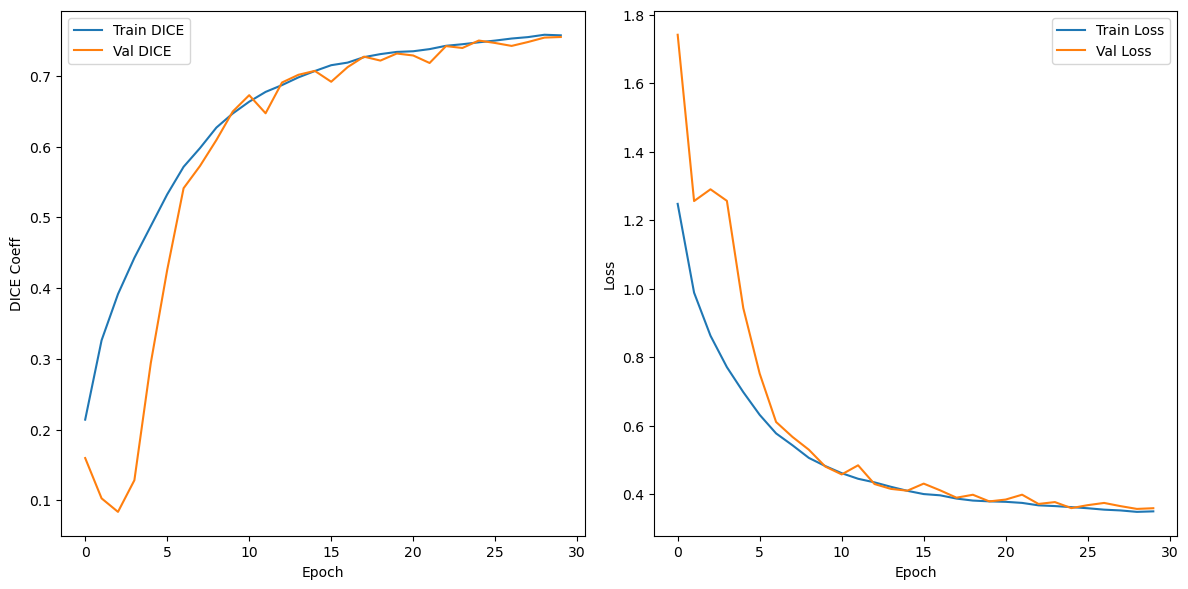

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_dices, label="Train DICE")
plt.plot(range(epochs), val_dices, label="Val DICE")
plt.xlabel("Epoch")
plt.ylabel("DICE Coeff")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


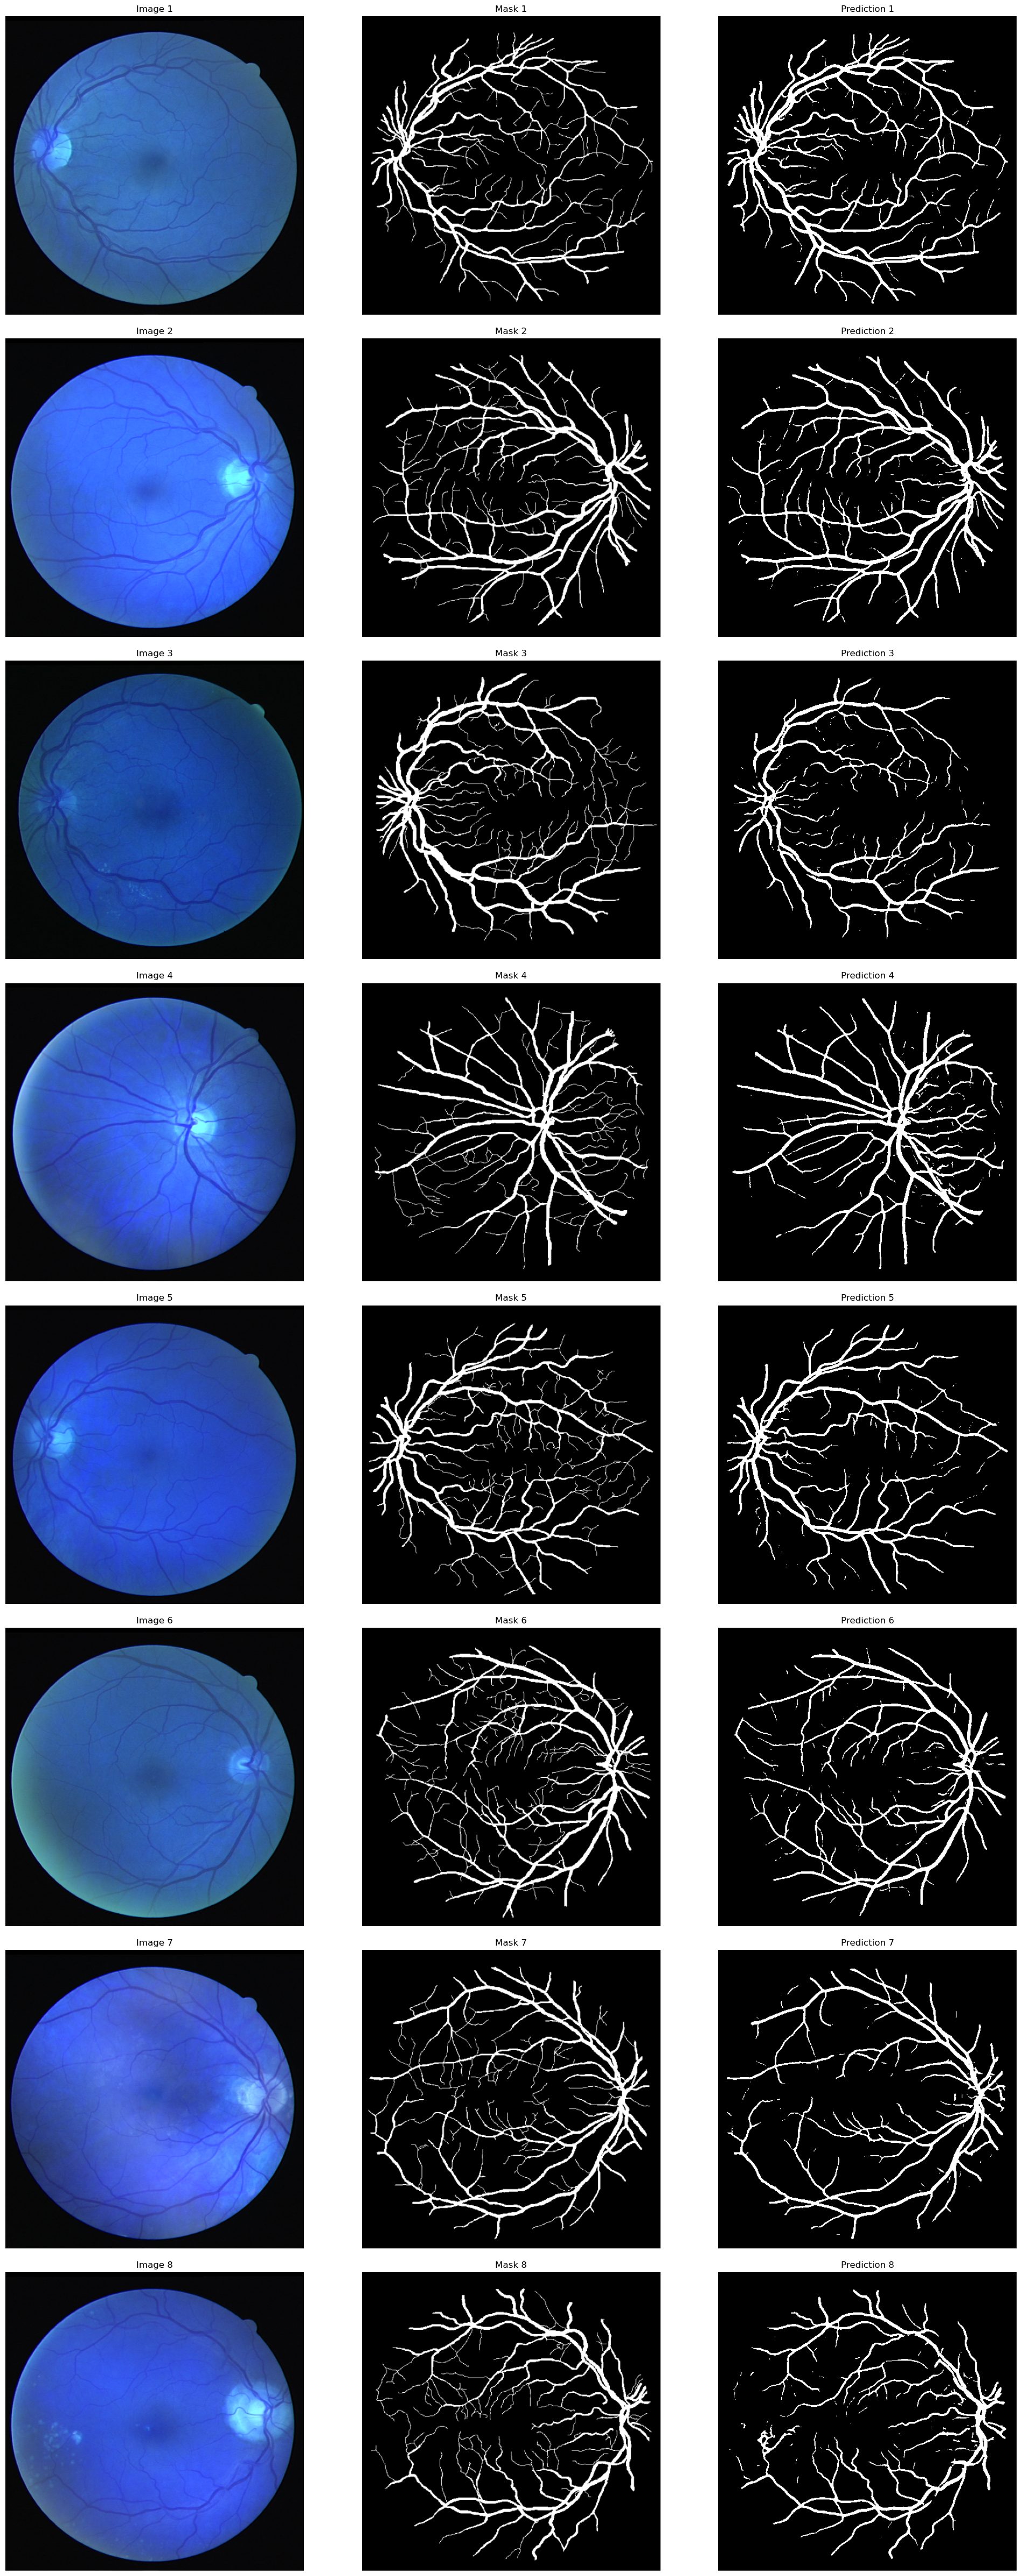

In [10]:
import torch
import matplotlib.pyplot as plt

images, masks = next(iter(test_loader))
with torch.no_grad():
    pred = model(images.to(device)).cpu().detach()
#     print(pred)
    pred = pred > 0.5
# print(pred)
def display_batch(images, masks, pred):
    fig, axes = plt.subplots(len(images), 3, figsize=(20, 6 * len(images)))
    fig.tight_layout()

    for i in range(len(images)):
        axes[i, 0].imshow(images[i].permute(1,2,0))
        axes[i, 0].set_title(f'Image {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Mask {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred[i].squeeze(), cmap='gray')
        axes[i, 2].set_title(f'Prediction {i+1}')
        axes[i, 2].axis('off')

    plt.show()

display_batch(images, masks, pred)


In [11]:
torch.save(model.state_dict(), 'retinal_blood_vessel1.pth')

In [12]:
from IPython.display import FileLink
FileLink(r'retinal_blood_vessel1.pth')

/kaggle/working/retinal_blood_vessel1.pth

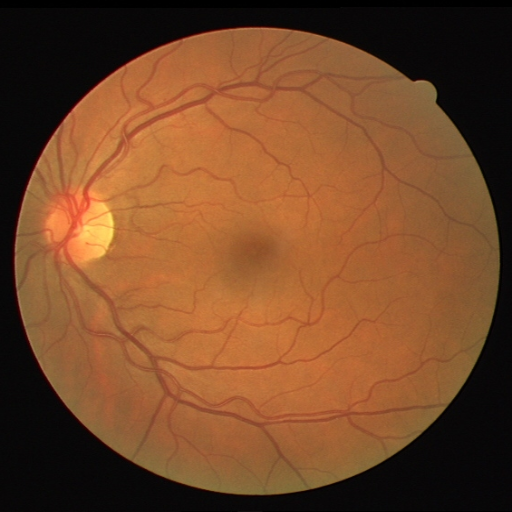

In [13]:
from PIL import Image

img = Image.open("/kaggle/input/augment-retina/test/images/01_test.png")

img

In [14]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

test_image = transform(img)
# test_image = test_dataset[0][0]
# print(test_image)
test_image = test_image.unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
test_image = test_image.to(device)


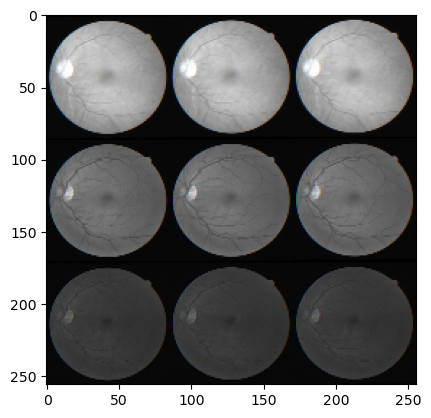

In [15]:
# train_dataset[0]
plt.imshow(test_image[0].reshape(256,256,3).cpu().numpy())

In [16]:
test_image

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0314, 0.0314, 0.0314,  ..., 0.0314, 0.0314, 0.0314],
          [0.0314, 0.0314, 0.0353,  ..., 0.0314, 0.0314, 0.0275],
          [0.0314, 0.0314, 0.0314,  ..., 0.0196, 0.0157, 0.0157]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0275, 0.0275, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 0.0275, 0.0275, 0.0275],
          [0.0235, 0.0235, 0.0235,  ..., 0.0196, 0.0157, 0.0157]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0

In [17]:
pre_trained_path="/kaggle/working/retinal_blood_vessel1.pth"
state_dict = torch.load(pre_trained_path)
model.load_state_dict(state_dict)
model.eval()
print(f'model {pre_trained_path} loaded')
with torch.no_grad():
    result=model(test_image)
    result=result>-1
        

model /kaggle/working/retinal_blood_vessel1.pth loaded


In [18]:
result

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]]], device='cuda:0')

In [19]:
# output = torch.argmax(result, dim=1)
output = result[0]
output.shape

torch.Size([1, 256, 256])

In [20]:
output

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')

In [21]:
import numpy as np
# output=output.cpu()
# output.numpy()
np_arr = output.detach().cpu().numpy()
np_arr

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [22]:
type(np_arr)

numpy.ndarray

In [23]:
np_arr.shape

(1, 256, 256)

In [24]:
np_arr=np_arr.squeeze()
np_arr.shape

(256, 256)

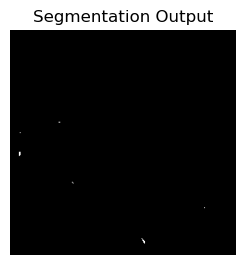

In [25]:

import matplotlib.pyplot as plt

# plt.subplot(1, 2, 1)
# plt.title('Input Image')
# plt.imshow(test_image.squeeze().permute(1, 2, 0))
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmentation Output')
# plt.imshow(output.numpy, cmap='gray')
im = plt.imshow(np_arr,cmap="gray")
plt.axis('off')

plt.show()